# Modeling with Regression Algorithms

A quick review of regression concepts from intro lesson:

**Regression** is a **supervised machine learning** technique used to model the relationships between one (**simple**) or more (**multiple**) features (independent) and how they contribute to one (**univariate**) or more (**multivariate**) target variables (dependent), represented by a **continuous variable**.

## About Modeling

We want to find a function that 'mimics' or 'models' this relationship, so that when new observations are available, predictions of the target variable can be made by computing the function with the new input feature values.

Modeling is an attempt to generalize the information in our sample so that it can be applied to unseen data with similar performance.

### How it works

The algorithm attempts to find the “best” choices of values for the parameters, which in a linear regression model are the coefficients, $b_{i}$, in order to make the formula as “accurate” as possible, i.e. minimize the error. There are different ways to define the error. But whichever evaluation metric is selected, we find the line of best fit by identifying the parameters that minimize that error.  

Once estimated, the parameters (intercept and coefficients) allow the value of the target variable to be obtained from the values of the feature variables. 

In simple linear regression, our parameters are the y-intercept ($b_{0}$) and the coefficient ($b_{1}$) of the line $y = b_{0} + b_{1}x$. 

In the case we have a quadratic function ($y = b_{0} + b_{1}x^{2}$), we still have a linear model due to the fact that $x^2$ is in fact a feature, and the coefficients/weights associated with that feature is still linear.  
To convert the original features into their higher order terms we will use the `PolynomialFeatures` class provided by sklearn. Then, we train the model using Linear Regression.

In multiple linear regression case with n features, our parameters are y-intercept ($b_{0}$) and n coefficients ($b_{1},...,b_{n}$) of the line $y = b_{0} + b_{1}x_{1} + b_{2}x_{2} + ... b_{n}x_{n}$. 

### General Steps in Modeling:

1. Identify identify an applicable sklearn machine learning algorithm to use to model our data   

2. Define: Initialize the algorithm with the hyperparameters defined in a way that fit our use-case.      

3. Fit: Now that we have given a general algorithm the basic "requirements" for how to model our data, we will instruct the initialized model object (i.e. the algorithm + our instructions) to model our y as a function of X. That is, the model object will 'fit' to our data. In the case of linear regression, we will provide our features (X) and our target (y) data, and the algorithm will find the linear function that minimize the sum of the squared errors. Given that a linear function is defined by the coefficients and the degrees (if polynomial), the linear model returns the coefficients for the line of best fit. To summarize, `Fit` returns the best model of our data the algorithm could create, given the hyperparameters (or requirements), the features, and the sample we provided the algorithm.   

4. Predict: What do you do with this "model" now? Well, you can look at the details under the hood, like the coefficients or parameters that were returned. We can also run the newly created model on our in-sample data (train) to predict y based on providing the same features that were provided in the fitting of the model.   

5. Evaluate: Compute metric such as RMSE to be used to compare future models.   

6. Repeat: Beginning at either step 1 (finding a new algorithm) or step 2 (refining hyperparameters), build another model and evaluate on in-sample data by walking through the steps. (how many times you repeat depends on a number of factors).   

7. Select best model -> run on out-of-sample data (test dataset) -> evaluation using same metric.   

The python implementation of the steps above looks like this:

1. Create an instance of the sklearn class to use.
1. Fit the models with the training data.
1. Use the models to make predictions.
1. Evaluate the models, both seperately and all together.

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings("ignore")

import wrangle
import features

## Wrangle

Here we will acquire and clean the data, split the data into train and test datasets, and split the data into our X and y. This dataset does not need it, but this is where we might perform scaling as well.

In [2]:
# acquire data and remove null values 
df = wrangle.wrangle_grades()

In [3]:
# split into train, validate, and test sets
train_and_validate, test = train_test_split(df, random_state=123)
train, validate = train_test_split(train_and_validate, random_state=123)

In [4]:
# Split into X and y
X_train = train.drop(columns='final_grade')
y_train = train[['final_grade']]

# Validate split
X_validate = validate.drop(columns="final_grade")
y_validate = validate[["final_grade"]]

# Test split
X_test = test.drop(columns='final_grade')
y_test = test[['final_grade']]

## Feature Elimination

Select the top 2 features using Recursive Feature Elimination


In [5]:
# Initialize the Linear Regression Object 
lm = LinearRegression()

rfe = RFE(lm, 2)

# Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train)  

Get list of feature names that were selected so that we can have context as we evaluate models we build. 

In [6]:
# boolean mask for each variable of whether it was selected or not. 
mask = rfe.support_

# select the column names of the features that were selected and convert them to a list for future use. 
rfe_features = X_train.columns[mask]

# print them out here for our reference
print(f'selected {len(rfe_features)} features:', ', '.join(rfe_features))

selected 2 features: exam1, exam3


## Multiple Linear Regression Model 

First we initialize the ML Algorithm Object. We already did this above in the feature elimination process, but that won't always be used and sometimes we will want to use a different algorithm, so we will demonstrate this stage of the process here also for consistency. 

In [7]:
lm = LinearRegression()
lm

LinearRegression()

Next we fit the model. This is where we feed the training data into the models, and model parameters are "learned".

We can return the linear model and the parameters (y_intercept & coefficients) that the model calulated. 

In [8]:
# Fitting the data to model
lm.fit(X_rfe, y_train)

LinearRegression()

In [9]:
print("Linear Model:", lm)

print("intercept: ", lm.intercept_)

print("features: ", rfe_features)
print("coefficients: ", lm.coef_)

Linear Model: LinearRegression()
intercept:  [12.14476092]
features:  Index(['exam1', 'exam3'], dtype='object')
coefficients:  [[0.59343236 0.27423512]]


Here we fit the model on our X_rfe (which is X_train with one variable filtered out) and then inspected various properties of the model after it was fit.

We can now call `.predict` to get the predicted y-values.

We will call the predicted y value `yhat_lm` and append to our `y_train` dataframe for easier evaluation analysis.

In [10]:
y_train['yhat_lm'] = lm.predict(X_rfe)

y_train.head()

,final_grade,yhat_lm
10,68,65.760296
15,87,86.444967
42,85,84.983867
51,72,75.075365
46,76,76.032957


Evaluate RMSE

In [11]:
RMSE_lm = np.sqrt(mean_squared_error(y_train.final_grade, y_train.yhat_lm))
RMSE_lm

print("linear model\n  Root mean squared error: {:.3}".format(RMSE_lm))

linear model
  Root mean squared error: 1.65


Return the coefficient of determination R^2 of the prediction:

In [12]:
r2_lm = lm.score(X_rfe, y_train.final_grade)

print(f'{r2_lm:.2%} of the variance in the student''s final grade can be explained by the grades on exam 1 and 3.')

97.49% of the variance in the students final grade can be explained by the grades on exam 1 and 3.


Given the intercept and the coefficients, we can write the regression function. 

In [13]:
output = "{} = {:.4} + {:.2} * {} + {:.3} * {}".format(
    y_train.columns[0],
    lm.intercept_[0],
    lm.coef_[0][0],
    rfe_features[0],
    lm.coef_[0][1],
    rfe_features[1],
)
print(output)

final_grade = 12.14 + 0.59 * exam1 + 0.274 * exam3


!!!tip "sklearn conventions"
    Sklearn uses an underscore suffix to indicate properties which are learned from the data (as opposed to being inherit to the model itself).

## Polynomial Regression Model 

In [14]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_rfe)

poly.get_feature_names()

['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2']

In [15]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train.final_grade)
y_train['yhat_poly'] = lm_poly.predict(X_poly)

In [16]:
RMSE_poly = np.sqrt(mean_squared_error(y_train.final_grade, y_train.yhat_poly))
RMSE_poly

print("polynomial model\n  Root mean squared error: {:.3}".format(RMSE_poly)) 

polynomial model
  Root mean squared error: 1.28


In [17]:
y_train.head()

,final_grade,yhat_lm,yhat_poly
10,68,65.760296,67.187419
15,87,86.444967,85.564223
42,85,84.983867,84.280514
51,72,75.075365,75.097629
46,76,76.032957,76.324583


## Baseline Model

In [18]:
# set predictions to be the mean of all final grades
y_train['yhat_baseline'] = df['final_grade'].mean()

# compute the RMSE
RMSE_bl = np.sqrt(mean_squared_error(y_train.final_grade, y_train.yhat_baseline))
print("Baseline (ŷ = ȳ)\n  Root mean squared error: {:.3}".format(RMSE_bl)) 

# no need to compute R-2 because it will be a 0! But we will demonstrate here:
evs = explained_variance_score(y_train.final_grade, y_train.yhat_baseline)
print('  {:.2%} of the variance in the student''s final grade can be explained by the grades on exam 1 and 3.'.format(evs))

Baseline (ŷ = ȳ)
  Root mean squared error: 10.4
  0.00% of the variance in the students final grade can be explained by the grades on exam 1 and 3.


## Pull them all together

At this point, we have a dataframe, `y_train` full of the actual final grade values, as well as all of the predictions our models have made.

In [19]:
y_train.head()

,final_grade,yhat_lm,yhat_poly,yhat_baseline
10,68,65.760296,67.187419,81.970588
15,87,86.444967,85.564223,81.970588
42,85,84.983867,84.280514,81.970588
51,72,75.075365,75.097629,81.970588
46,76,76.032957,76.324583,81.970588


It can be helpful to visualize all of the models' predictions:

Text(0.5, 1.0, 'Predicted vs Actual Final Grade')

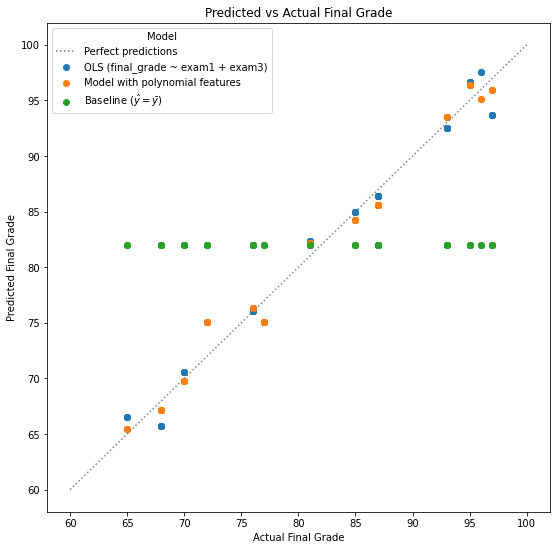

In [20]:
plt.figure(figsize=(9, 9))

plt.scatter(y_train.final_grade, y_train.yhat_lm, label='OLS (final_grade ~ exam1 + exam3)', marker='o')
plt.scatter(y_train.final_grade, y_train.yhat_poly, label='Model with polynomial features', marker='o')
plt.scatter(y_train.final_grade, y_train.yhat_baseline, label=r'Baseline ($\hat{y} = \bar{y}$)', marker='o')
plt.plot([60, 100], [60, 100], label='Perfect predictions', ls=':', c='grey')

plt.legend(title='Model')
plt.ylabel('Predicted Final Grade')
plt.xlabel('Actual Final Grade')
plt.title('Predicted vs Actual Final Grade')

## Evaluate models on `validate`, tune, and then evaluate on `train`

Once you've produced some models and evaluated their performance on the `train` dataset, it's important to see how they perform on out of sample data.

1. Build a handful of models that perform well on `train`. Then evaluate how these models perform on out-of-sample data from the `validate` data set.
2. Experiment with your hyperparameters, perform additional feature engineering, and create more refined models that perform well on `validate`. Test how well each model performs on `validate`. 
    - In this way, we're using out-of-sample data from `validate` to improve our model. 
    - Because we're using out-of-sample data to improve our models, the validate can no longer be considered out-of-sample. 
3. Once we have our model that performs the best on `validate`, it's time to see how well it will perform on the fresh out-of-sample data from the `test` set.

## Exercises

Create a notebook named `model.ipynb` for this exercise. 

---

Using the data on student grades from this lesson, complete the following:

1. Split the data into train, validate, and test datasets.
1. Create a model that uses exam 1 to predict the final grade.
1. Create a model that uses exam 2 to predict the final grade.
1. Compare your models in the following manner:
    - Calculate the mean squared error
    - Visualize the residuals. Create a seperate visualization for each model.
    - Visualize the actual vs the predicted values. Create a seperate visualization for each model.
    - **Bonus**: Combine the seperate visualizations for each model into a single visualization. Is this visual helpful?
1. Create a model that uses exam 1 and exam 3 to predict final grade. How does this model compare to your previous ones?
1. Take your best preforming model and measure its performance on the `validate` data set. How does the performance differ between train and validate?
1. Make a 4th model with a slight difference like one more/less feature or a single hyperparameter that's different to see if you can beat that the last model's performance on validate.
1. Tune your models using validate to improve performance. Select the model w/ the best performance and evaluate that one on test, to get a more clear understanding of how it will perform on out-of-sample data.

---

Our scenario continues:

As a customer analyst, I want to know who has spent the most money with us over their lifetime. I have monthly charges and tenure, so I think I will be able to use those two attributes as features to estimate total_charges. I need to do this within an average of $5.00 per customer. 

1. Run all your previous scripts that acquired, prepared, split, and scaled the telco churn data.
1. Fit 3 different linear models to your data, one with just `tenure`, one with just `monthly_charges`, and one with both.
1. Evaluate the models and your baseline.
1. Select the model that performed the best, and evaluate it with your validate data.
1. Make a 4th model with a slight difference like one more feature or a single hyperparameter that's different to see if you can beat that the last model's performance on `validate`.
1. Tune your models using `validate` to improve performance. Select the model w/ the best performance and evaluate that one on `test`, to get a more clear understanding of how it will perform on out-of-sample data. 
